**About**

Notebook ini akan mencoba manggabungkan data rumah sakit rujukan dengan data geospasial kota. Data geospasial kota ini belum di-support dalam fitur Tableau.

### Get shapefile

Satu sumber yang sudah merangkum dan membuka data geospasial dengan baik adalah [GADM](https://gadm.org/download_country_v3.html)

In [1]:
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

In [2]:
url_gadm_shapefile = "https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip"
zippath = 'gadm36_IDN_shp.zip'

download_url(url_gadm_shapefile, zippath)

gadm36_IDN_shp.zip: 161MB [01:25, 1.88MB/s]                           


In [3]:
!unzip gadm36_IDN_shp.zip -d ./

Archive:  gadm36_IDN_shp.zip
 extracting: ./gadm36_IDN_1.cpg      
  inflating: ./gadm36_IDN_1.dbf      
  inflating: ./gadm36_IDN_1.prj      
  inflating: ./gadm36_IDN_1.shp      
  inflating: ./gadm36_IDN_1.shx      
 extracting: ./gadm36_IDN_2.cpg      
  inflating: ./gadm36_IDN_2.dbf      
  inflating: ./gadm36_IDN_2.prj      
  inflating: ./gadm36_IDN_2.shp      
  inflating: ./gadm36_IDN_2.shx      
 extracting: ./gadm36_IDN_3.cpg      
  inflating: ./gadm36_IDN_3.dbf      
  inflating: ./gadm36_IDN_3.prj      
  inflating: ./gadm36_IDN_3.shp      
  inflating: ./gadm36_IDN_3.shx      
 extracting: ./gadm36_IDN_4.cpg      
  inflating: ./gadm36_IDN_4.dbf      
  inflating: ./gadm36_IDN_4.prj      
  inflating: ./gadm36_IDN_4.shp      
  inflating: ./gadm36_IDN_4.shx      
  inflating: ./license.txt           


### Get base data - Rumah Sakit

https://docs.google.com/spreadsheets/d/1WmJEoyHQb6Q4EOfM2jxVUtezitlpvL9WZ-0iD3qEFLA

In [5]:
import pandas as pd

df_rs = pd.read_csv("/content/Data Rumah Sakit Rujukan_COVID19-edit Datin (1) - Rumah Sakit RJ.csv")
df_rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   No                       132 non-null    int64  
 1   Kode Prov                132 non-null    int64  
 2   Kode Kab                 129 non-null    float64
 3   Nama kab/kota            132 non-null    object 
 4   Provinsi                 132 non-null    object 
 5   Code                     129 non-null    object 
 6   Kode SDMK                131 non-null    object 
 7   Nama RS Rujukan          132 non-null    object 
 8   Jumlah                   132 non-null    int64  
 9   Latitude                 132 non-null    float64
 10  Longitude                132 non-null    float64
 11  Alamat                   132 non-null    object 
 12  No Telp                  131 non-null    object 
 13  E-mail                   129 non-null    object 
 14  Referensi                1

In [6]:
df_rs[df_rs['Kode Kab'].isna()]

,No,Kode Prov,Kode Kab,Nama kab/kota,Provinsi,Code,Kode SDMK,Nama RS Rujukan,Jumlah,Latitude,Longitude,Alamat,No Telp,E-mail,Referensi,dokter umum,dokter gigi,dr. Sp. Penyakit dalam,dr. Sp Anak,dr. Sp Bedah,dr. Sp. Obsgyn,dr. Sp. Radiologi,dr. Sp. Anestesi,dr. Sp Patologi Klinik,dr. Sp Patologi Anatomi,dp. Bedah Thoraks,dr. Sp. Paru,Perawat,Bidan,Farmasi,ATLM
13,14,21,NaN,Kota Batam,KEPULAUAN RIAU,NaN,R2071034,RSBP Batam,1,1.129668,103.931488,"Jl. Dr. Cipto Mangunkusumo No.1, Sekupang,Batam","(0778-322046, 322121)",rsbp.official@gmail.com,KEPUTUSAN MENTERI KESEHATAN REPUBLIK INDONESIA...,28.0,5.0,7.0,2.0,4.0,8.0,4.0,5.0,2.0,1.0,1.0,2.0,159.0,33.0,39.0,12.0
37,38,31,NaN,Kota Jakarta TImur,DKI JAKARTA,NaN,R3172072,RS Umum Bhayangkara Tk. I R.Said Sukanto,1,-6.269255,106.870708,"Jl. Raya Bogor Kramat Jati, Jakarta Timur",(021-8093288),subbagren.tk1@gmail.com,KEPUTUSAN MENTERI KESEHATAN REPUBLIK INDONESIA...,50.0,7.0,9.0,4.0,7.0,6.0,4.0,7.0,1.0,2.0,2.0,3.0,924.0,70.0,125.0,62.0
124,125,81,NaN,Kota Ambon,MALUKU,NaN,NaN,RSUP dr J.\nLeimena,1,-3.661386,128.177785,Desa Rumah 3 Kec. Teluk Ambon,NaN,NaN,KEPUTUSAN MENTERI KESEHATAN REPUBLIK INDONESIA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Shapely

Model python yang meungkinkan kita bekerja dengan shapefile (salah satu jenis data geospasial)


In [7]:
!pip install shapely
!pip install geopandas

     |████████████████████████████████| 972kB 5.1MB/s 
     |████████████████████████████████| 14.8MB 334kB/s 
     |████████████████████████████████| 6.5MB 30.7MB/s 


In [8]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

df_geo = gpd.read_file('gadm36_IDN_2.shp') # IDN_2 adalah data geospasial level City, 1-Provinsi 2-KotaKab 3-Kecamatan
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_0      502 non-null    object  
 1   NAME_0     502 non-null    object  
 2   GID_1      502 non-null    object  
 3   NAME_1     502 non-null    object  
 4   NL_NAME_1  0 non-null      object  
 5   GID_2      502 non-null    object  
 6   NAME_2     502 non-null    object  
 7   VARNAME_2  0 non-null      object  
 8   NL_NAME_2  0 non-null      object  
 9   TYPE_2     502 non-null    object  
 10  ENGTYPE_2  502 non-null    object  
 11  CC_2       501 non-null    object  
 12  HASC_2     498 non-null    object  
 13  geometry   502 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 55.0+ KB


In [9]:
mpolygon = df_geo.loc[0,'geometry']
point = Point(95.452811, 5.518212) #longitude, latitude within BandaAceh

In [10]:
print(mpolygon.contains(point)) # check if polygon contains point
print(point.within(mpolygon)) # check if a point is in the polygon 

False
False


In [11]:
df_geo

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IDN,Indonesia,IDN.1_1,Aceh,None,IDN.1.2_1,Aceh Barat,None,None,Kabupaten,Regency,1107,ID.AC.AB,"POLYGON ((96.13205 4.13408, 96.13216 4.13404, ..."
1,IDN,Indonesia,IDN.1_1,Aceh,None,IDN.1.1_1,Aceh Barat Daya,None,None,Kabupaten,Regency,1112,ID.AC.AD,"MULTIPOLYGON (((96.80518 3.72169, 96.80582 3.7..."
2,IDN,Indonesia,IDN.1_1,Aceh,None,IDN.1.3_1,Aceh Besar,None,None,Kabupaten,Regency,1108,ID.AC.AR,"MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2..."
3,IDN,Indonesia,IDN.1_1,Aceh,None,IDN.1.4_1,Aceh Jaya,None,None,Kabupaten,Regency,1116,ID.AC.AJ,"MULTIPOLYGON (((95.87688 4.36750, 95.87684 4.3..."
4,IDN,Indonesia,IDN.1_1,Aceh,None,IDN.1.5_1,Aceh Selatan,None,None,Kabupaten,Regency,1103,ID.AC.AS,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,IDN,Indonesia,IDN.33_1,Yogyakarta,None,IDN.33.1_1,Bantul,None,None,Kabupaten,Regency,3402,ID.YO.BA,"POLYGON ((110.32923 -8.00613, 110.32927 -8.006..."
498,IDN,Indonesia,IDN.33_1,Yogyakarta,None,IDN.33.2_1,Gunung Kidul,None,None,Kabupaten,Regency,3403,ID.YO.GK,"MULTIPOLYGON (((110.66244 -8.17778, 110.66234 ..."
499,IDN,Indonesia,IDN.33_1,Yogyakarta,None,IDN.33.3_1,Kota Yogyakarta,None,None,Kota,City,3471,ID.YO.YO,"POLYGON ((110.40143 -7.81923, 110.40170 -7.819..."
500,IDN,Indonesia,IDN.33_1,Yogyakarta,None,IDN.33.4_1,Kulon Progo,None,None,Kabupaten,Regency,3401,ID.YO.KP,"POLYGON ((110.20530 -7.98388, 110.20493 -7.984..."


In [12]:
df_geo[df_geo['CC_2'].isna()]

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
476,IDN,Indonesia,IDN.32_1,Sumatera Utara,None,IDN.32.14_1,Lake Toba,None,None,Water Body,Water Body,None,None,"POLYGON ((99.12016 2.42754, 99.12036 2.42942, ..."


In [13]:
# drop sample karena bukan salah satu Kabupaten/Kota
df_geo = df_geo.drop(476, axis=0)

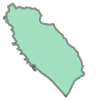

In [14]:
df_geo.loc[3,'geometry']

In [15]:
mpolygon = df_geo.loc[3,'geometry']

print(mpolygon.centroid.x)
print(mpolygon.centroid.y)

95.67851139908825
4.833062320869889


In [16]:
mpolygon = df_geo.loc[501,'geometry']

print(mpolygon.centroid.x)
print(mpolygon.centroid.y)

110.38349070596588
-7.715434582698144


In [17]:
df_geo['centroid_longitude'] = df_geo['geometry'].apply(lambda pol: pol.centroid.x)
df_geo['centroid_latitude'] = df_geo['geometry'].apply(lambda pol: pol.centroid.y)

In [18]:
# df_geo
# df_geo.info()

### Imputer

Masukkan Kode Kabupaten/Kota yang sebelumnya bernilai Null

In [19]:
kode_kab_add = {
    "Batam": 2171.0,
    "Jakarta Timur": 3172.0,
    "Ambon": 8171.0
}

for kab, kode in kode_kab_add.items():
  ix = df_rs[df_rs["Nama kab/kota"] == kab].index
  df_rs.loc[ix,'Kode Kab'] = kode

converter = lambda x: str(x).split('.')[0]
df_rs['Kode Kab'] = df_rs['Kode Kab'].apply(converter)

### RS Terdekat

In [20]:
df_geo['rs_name'] = None
df_geo['rs_longitude'] = None
df_geo['rs_latitude'] = None

for ix_city, row_city in df_geo.iterrows():
  city_point = Point(row_city['centroid_longitude'], row_city['centroid_latitude'])
  rs_nearest_name = None
  rs_nearest_coord = None
  rs_nearest_dist = 0
  
  for ix_rs, row_rs in df_rs[['Nama RS Rujukan', 'Longitude', 'Latitude']].iterrows():
    rs_point = Point(row_rs['Longitude'], row_rs['Latitude'])

    if (rs_nearest_name == None) or (city_point.distance(rs_point) < rs_nearest_dist):
      rs_nearest_name = row_rs['Nama RS Rujukan']
      rs_nearest_coord = row_rs['Longitude'], row_rs['Latitude']
      rs_nearest_dist = city_point.distance(rs_point)
  
  df_geo.loc[ix_city, 'rs_name'] = rs_nearest_name
  df_geo.loc[ix_city, 'rs_longitude'] = rs_nearest_coord[0]
  df_geo.loc[ix_city, 'rs_latitude'] = rs_nearest_coord[1]

In [25]:
selected_columns = ['CC_2','NAME_2','centroid_longitude','centroid_latitude','rs_name','rs_longitude','rs_latitude']
df_geo[selected_columns]

,CC_2,NAME_2,centroid_longitude,centroid_latitude,rs_name,rs_longitude,rs_latitude
0,1107,Aceh Barat,96.185295,4.456668,RSU Cut Meutia Lhoksemawe,97.149,5.1892
1,1112,Aceh Barat Daya,96.878320,3.824899,RSU Cut Meutia Lhoksemawe,97.149,5.1892
2,1108,Aceh Besar,95.514989,5.380545,RSU Dr. Zainoel Abidin,95.3411,5.56997
3,1116,Aceh Jaya,95.678511,4.833062,RSU Dr. Zainoel Abidin,95.3411,5.56997
4,1103,Aceh Selatan,97.435373,3.162858,RS Umum Daerah Kabanjahe,98.4546,3.13857
...,...,...,...,...,...,...,...
497,3402,Bantul,110.354695,-7.901664,RSUD Panembahan Senopati,110.338,-7.89272
498,3403,Gunung Kidul,110.612085,-7.994254,RSUP dr. Soeradji Tirtonegoro Klaten,110.588,-7.71518
499,3471,Kota Yogyakarta,110.374354,-7.803291,RSUD Kota Yogyakarta,110.378,-7.82586
500,3401,Kulon Progo,110.167122,-7.819815,RSUD Wates,110.128,-7.89321


### Output

In [22]:
# df_rs = df_rs.merge(df_geo, how='left', left_on="Kode Kab", right_on="CC_2")
# df_rs.info()

In [23]:
# df_rs.to_csv("data_RSrujukanCovid.csv", sep=",", index=False)

In [26]:
df_geo[selected_columns].to_csv("Rumah Sakit Rujukan Terdekat.csv", index=False)